In [1]:
import pandas as pd
import numpy as np
op = pd.read_parquet("hk_price_open_all.parquet")
cl = pd.read_parquet("hk_price_close_all.parquet")
vol = pd.read_parquet("hk_volume_all.parquet")

In [ ]:
import psycopg2 # type: ignore
import matplotlib.pyplot as plt # type: ignore
import pandas as pd # type: ignore
from tqdm import tqdm # type: ignore
import numpy as np # type: ignore
import pandas as pd # type: ignore
import plotly.graph_objects as go # type: ignore
import yfinance as yf # type: ignore
import os
import warnings
warnings.filterwarnings("ignore")
# functions
def get_demean_weighting(factor):
    df1 = factor.dropna(axis='columns', how='all').copy()
    demean = df1.sub(df1.mean(axis=1), axis=0)
    weighting = demean.div(demean.abs().sum(axis=1), axis=0)
    return weighting
def _reweighting_equal(weighting:pd.DataFrame):
    def equal_weight(row: pd.Series):
        count_larger_than_zero = (row != 0).sum()
        if count_larger_than_zero > 0:
            row = row.apply(lambda x: 1 / count_larger_than_zero if x > 0 else x)
        return row
    return weighting.apply(equal_weight, axis=1)
def intraday_shifted_input_signal_pct_output_plot(ln_, pct_calculating_profit, quantile=10, type_='cumsum'):
        
    time_length = len(ln_)
    quantile_column = [[None] * quantile] * time_length
    quantile_df = pd.DataFrame(quantile_column)
    
    # Process each time step (row in ln_)
    for da in range(time_length):
        row = ln_.iloc[da, :]
        col = row.sort_values(ascending=False).index
        quantile_step = 100 // quantile  # Partition size for each quantile (fixed size of 10)
        
        for i in range(quantile):
            quantile_df.iloc[da, i] = list(col[i*quantile_step : (i+1)*quantile_step])

    holdings = []
    index = ln_.index
    quantiles = [None] * quantile

    # Loop through each quantile
    for qt_iter in range(quantile):
        quantile_1 = quantile_df.iloc[:, qt_iter]
        if qt_iter == 0:
            holdings = quantile_1

        df_1 = ln_.copy()

        # Set non-quantile columns to 0 for the current quantile
        for i in range(len(quantile_1)):
            df_1.loc[index[i], ~df_1.columns.isin(quantile_1[i])] = 0

        weighting_1 = -_reweighting_equal(df_1)
        ret = pct_calculating_profit.loc[weighting_1.index[0]:] * weighting_1
        
        if type_ == "cumsum":
            quantiles[qt_iter] = ret.sum(axis=1).cumsum()
        else:
            quantiles[qt_iter] = (1 + ret.sum(axis=1)).cumprod() - 1
    
    quantilized_cumsum = pd.DataFrame(quantiles).T
    fig = go.Figure()
    
    # Plot results for each quantile
    for i in range(len(quantilized_cumsum.columns)):
        fig.add_trace(go.Scatter(
            x=quantilized_cumsum.index,
            y=quantilized_cumsum.iloc[:, i],
            name=f"{i + 1}th quantile",
            mode="lines",
            yaxis="y1"
        ))
    
    fig.show()
    return holdings


In [98]:
import numpy as np
final_list = []
top = 100
index_op = op.index
index_cl = cl.index
index_vol = vol.index

if (index_op == index_cl).all() and (index_cl == index_vol).all():
    print("All indices are identical")

for index, time_iter in enumerate(index_op):
    if index == 0: continue
    tops = vol.iloc[index, :].sort_values(ascending=False)[:top].index
    op_t = op.iloc[index, :][tops]
    cl_t = cl.iloc[index, :][tops]
    ln_t = np.log(cl_t / op_t)
    
    # Scale ln_t to the range [1, 2]
    ln_min = ln_t.min()
    ln_max = ln_t.max()
    ln_t_scaled = 1 + (ln_t - ln_min) / (ln_max - ln_min) * (2 - 1)
    
    final_list.append(ln_t_scaled)

pct_calculating_profit = cl / op - 1  # index: 當天收益


All indices are identical


In [99]:
ln_ = pd.concat(final_list, axis=1).T.fillna(0)

In [101]:
holdings = intraday_shifted_input_signal_pct_output_plot(ln_.shift(0), pct_calculating_profit.shift(-2), quantile=10, type_='cumsum')


In [73]:
holdings.index = op.index
holdings

Date
2020-01-02    [1064.HK, 1701.HK, 0732.HK, 1919.HK, 1731.HK, ...
2020-01-03    [8420.HK, 0815.HK, 1773.HK, 0755.HK, 3800.HK, ...
2020-01-06    [2885.HK, 9911.HK, 1960.HK, 3690.HK, 3800.HK, ...
2020-01-07    [1011.HK, 1481.HK, 1701.HK, 1960.HK, 1870.HK, ...
2020-01-08    [0702.HK, 1530.HK, 0491.HK, 1765.HK, 8420.HK, ...
                                    ...                        
2025-01-21    [6080.HK, 1723.HK, 9911.HK, 0095.HK, 1102.HK, ...
2025-01-22    [1741.HK, 1252.HK, 0362.HK, 3337.HK, 1723.HK, ...
2025-01-23    [0464.HK, 0932.HK, 3830.HK, 1894.HK, 8611.HK, ...
2025-01-24    [1720.HK, 6869.HK, 9880.HK, 2252.HK, 0124.HK, ...
2025-01-27    [0707.HK, 8071.HK, 0124.HK, 1020.HK, 1357.HK, ...
Name: 0, Length: 1248, dtype: object

In [110]:
list_today = cl.iloc[-1, :][holdings.iloc[-1]].index

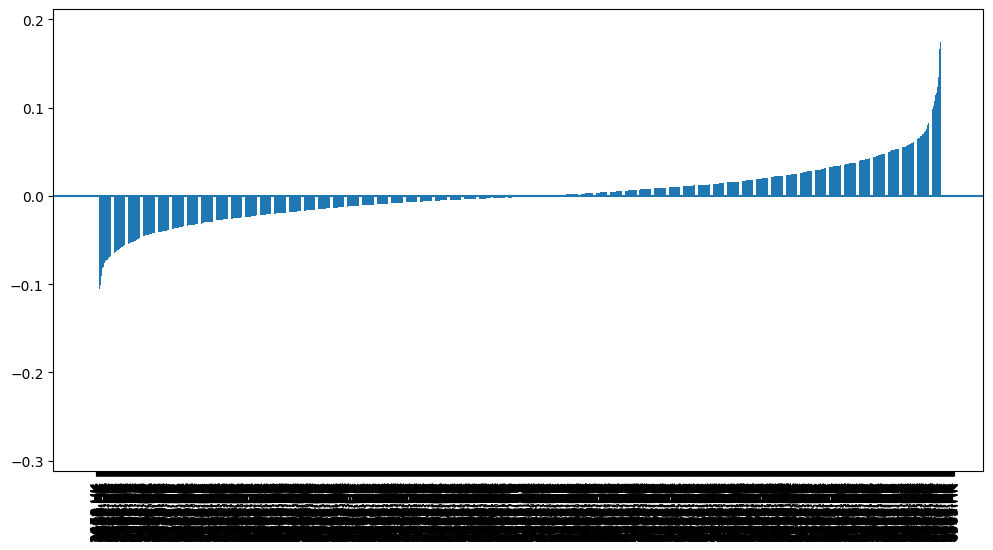

In [113]:
def IC_HK_OnOpen(ln_, pct_calculating_profit, bm=0) -> list:
    ind_corrcoef = pd.Series()
    ln_cols = list(ln_.columns)
    ln_array = np.array(ln_.iloc[1:, :]).T
    pct_array = np.array(pct_calculating_profit.iloc[1:, :]).T
    for i in range(ln_array.shape[0]):
        valid_mask = ~np.isnan(ln_array[i]) & ~np.isnan(pct_array[i])
        if valid_mask.any():
            corr = np.corrcoef(ln_array[i][valid_mask], pct_array[i][valid_mask])[0, 1]
            ind_corrcoef[ln_cols[i]] = corr
        else:
            ind_corrcoef[ln_cols[i]] = np.nan  
    ind_corrcoef = ind_corrcoef.sort_values(ascending=True)
    mean_corrcoef = np.nanmean(ind_corrcoef)
    if bm == 0:  
        list_tradable = list(ind_corrcoef[ind_corrcoef < -0].index)
    else:
        list_tradable = list(ind_corrcoef[ind_corrcoef < mean_corrcoef].index)
        
    plt.figure(figsize=(12, 6))
    plt.bar(ind_corrcoef.index, ind_corrcoef)
    plt.axhline(mean_corrcoef)
    plt.xticks(rotation=90)
    return sorted(list_tradable)

# 以ln_(所有被使用過的symbol)為基準計算Information Coefficient
cl_ic = cl[ln_.columns].iloc[-120:, :]
op_ic = op[ln_.columns].iloc[-120:, :]
ln_ic = np.log(cl_ic/op_ic) # index: 使用的時間
pct_for_ic = cl_ic/op_ic-1 # index: 當天收益
list_tradable = IC_HK_OnOpen(ln_.shift(1), pct_calculating_profit.iloc[1:, :], bm = 0)

In [114]:
list_trade = [i for i in list(list_today) if i in list_tradable]
list_trade_x_price = cl_ic.iloc[-1][list_trade]
list_trade_x_price

0124.HK    0.202
1020.HK    0.076
3896.HK    6.140
1691.HK    1.860
0493.HK    0.019
1918.HK    1.590
Name: 2025-01-27 00:00:00, dtype: float64